# PC lab: Generative models

In this PC lab, we will create a variational autoencoder, train it on MNIST, then use it to create our own images of digits.

## 1.1 Creating an autoencoder

Typically, an autoencoder will look something like this:

<img src='https://miro.medium.com/max/1400/1*gzJAJDLDavH_W7Zv2M2J7w.png' width = 600>

In essence, the first part of the network (the encoder) compresses the input to a lower dimensional space. It does this by (1) first using convolutions, (2) flattening, and (3) a linear layer at the end. The second part (the decoder) undergoes the same steps, but in reverse.

**Note that the steps undertaken in the encoder are exactly the same as with a CNN to do normal classification/regression tasks:**

<img src="https://raw.githubusercontent.com/gdewael/teaching/main/predmod/CNN/catdetectordrawing.png" width = 600>

So, in order to make an autoencoder, we can copy the model from the CNN PC lab, use it as an encoder, and then make the inverse of that model as the decoder, and place the two in sequence.

This was the CNN Classifier from the previous PC lab, with some small changes:

In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim = 64, kernel_size = 5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size, padding = "same"),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(hidden_dim)
        )
    def forward(self, x):
        return self.net(x) + x

class Encoder(nn.Module):
    def __init__(self, bottleneck_size = 8):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 8, 5),
            ResidualBlock(8),
            nn.MaxPool2d(2),
            ResidualBlock(8),
            nn.Conv2d(8, 16, 5),
            ResidualBlock(16),
            nn.MaxPool2d(2),
            ResidualBlock(16),
            nn.Conv2d(16, 16, 3),
        )
        self.flatten = nn.Flatten()
        self.MLP = nn.Linear(16 * 2 * 2, bottleneck_size)

    def forward(self, x):
        return self.MLP(self.flatten(self.cnn(x)))


For the decoder, we need inverse convolutions (and maybe inverse max pooling) operations to upscale our image again from its compressed representation to its original dimensions.

In PyTorch, we have these options:

- [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) also visualized [here](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html), the inverse of convolutions, also called deconvolution.
- [Upsample](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html#torch.nn.Upsample), performing simple non-parametric upscaling of inputs with any of a number of methods such as bilinear or bicubic upscaling.
- [MaxUnpool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxUnpool2d.html?highlight=maxunpool#torch.nn.MaxUnpool2d), performing the inverse of a previous max pooling operation. Essentially putting the maximal elements back in the location/index where they originally appeared before the previous max pooling. As such, this operation can only be used conjoined with a paired max pooling operation. (see examples in documentation).

For this PC lab, we simply recommend to replace Convolutions with `ConvTranspose2d` and Max-Pooling layers with `Upsample`.

Also, you will need to [Unflatten](https://pytorch.org/docs/stable/generated/torch.nn.Unflatten.html) your image after flattening it:

In [ ]:
# Illustration of unflatten:
# The dimensions we want:
C = 64
H = 16
W = 16

unflatten = nn.Unflatten(1, (C, H, W))
x = torch.randn(8, C*H*W) # imagine you have a tensor of this size before unflattening
print(x.shape)
y = unflatten(x)
print(y.shape)

torch.Size([8, 16384])
torch.Size([8, 64, 16, 16])


Following code illustrates the use of [Upsample](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html#torch.nn.Upsample)

In [ ]:
upsample = nn.Upsample(scale_factor = 2)
x = torch.randn(8, 64, 16, 16)
print(x.shape)
y = upsample(x)
print(y.shape)

torch.Size([8, 64, 16, 16])
torch.Size([8, 64, 32, 32])


<div class="alert alert-success">
<b>EXERCISE:</b>
<p> Implement a Decoder by creating the inverse of the Encoder model in the cell above. Create an autoencoder model that combines the Encoder and decoder.</p>
</div>

In [ ]:
class Decoder(nn.Module):
    def __init__(self, bottleneck_size = 8):
        super().__init__()
        self.MLP = nn.Linear(bottleneck_size, 16 * 2 * 2) # Your code here
        self.flatten = nn.Unflatten(1, (16, 2, 2)) # Your code here
        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(16, 16, 3),
            ResidualBlock(16),
            nn.Upsample(scale_factor=2),
            ResidualBlock(16),
            nn.ConvTranspose2d(16, 8, 5),
            ResidualBlock(8),
            nn.Upsample(scale_factor=2),
            ResidualBlock(8),
            nn.ConvTranspose2d(8, 1, 5),
        )

    def forward(self, x):
        return self.cnn(self.flatten(self.MLP(x)))


class AutoEncoder(nn.Module):
    def __init__(self, bottleneck_size = 8):
        super().__init__()
        self.encoder = Encoder(bottleneck_size = bottleneck_size)
        self.decoder = Decoder(bottleneck_size = bottleneck_size)

    def encode(self, x):
        return self.encoder(x)
    def decode(self, x):
        return self.decoder(x)
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

model = AutoEncoder(bottleneck_size = 8)

In [ ]:
x = torch.randn(8, 1, 28, 28)
print("original shape of x:")
print(x.shape)
print("Testing encoder:")
x_encoded = model.encode(x)
print(x_encoded.shape)
print("Testing decoder:")
x_decoded = model.decode(x_encoded)
print(x_decoded.shape)
print("Testing whole model at once:")
y = model(x)
print(y.shape)

original shape of x:
torch.Size([8, 1, 28, 28])
Testing encoder:
torch.Size([8, 8])
Testing decoder:
torch.Size([8, 1, 28, 28])
Testing whole model at once:
torch.Size([8, 1, 28, 28])


After successfully implementing the autoencoder, we can work on some real data. The following code loads in the MNIST data. It's exactly copy-pasted from the CNN PC-lab so you can skip it.

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

X_train = train_data.data
y_train = train_data.targets

X_test = test_data.data
y_test = test_data.targets

X_train = X_train / 255
X_test = X_test / 255

X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

np.random.seed(42)
train_indices, val_indices = np.split(np.random.permutation(len(X_train)), [int(len(X_train)*0.8)])
X_val = X_train[val_indices]
y_val = y_train[val_indices]
X_train = X_train[train_indices]
y_train = y_train[train_indices]

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, pin_memory=True, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, pin_memory=True, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, pin_memory=True, shuffle=True)

The following code trains the resulting autoencoder model on MNIST, using similar code as in previous PC labs. Some notes:
- We are reconstructing pixels. These are real-valued. Hence, this is a regression task and we're using the Mean squared error loss.
- Our batches return an X and a Y, but we're not using the labels Y here. Instead, the true "labels" for our loss is simply X.
- In contrast to previous PC labs - this code uses the GPU (note the `.to("cuda")` calls). This considerably speeds up training. If you're running this locally and don't have a GPU, delete these calls. If you're running on colab but it still returns an error: Go to `Runtime > Change runtime type`, and select an instance with GPUs.

In [ ]:
N_EPOCHS = 20

model = AutoEncoder(bottleneck_size = 8).to("cuda")

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(1, N_EPOCHS + 1):
    all_losses = []
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, _ = batch
        X_batch = X_batch.to("cuda")

        y_hat_batch = model(X_batch)

        loss = loss_function(y_hat_batch, X_batch) # Compute loss

        loss.backward()   # Calculate gradients
        optimizer.step()   # Update weights using defined optimizer

        all_losses.append(loss.item())
    train_loss = np.mean(all_losses)

    losses = []

    with torch.no_grad():
        model.eval()
        for batch in val_dataloader:
            X_batch, _ = batch
            X_batch = X_batch.to("cuda")

            y_hat_batch = model(X_batch)

            loss = loss_function(y_hat_batch, X_batch)

            losses.append(loss.item())

    print(i, '\t', train_loss, np.mean(losses))

1 	 0.08925626278544466 0.030127049282193185
2 	 0.028111366922656696 0.0255751413628459
3 	 0.025141710435971618 0.022545547674099605
4 	 0.023542392946779726 0.021098242588341237
5 	 0.022711723397485912 0.02197505582496524
6 	 0.02215602828003466 0.01993116101125876
7 	 0.021767392771318554 0.019561433475464584
8 	 0.02147829860666146 0.01981701906522115
9 	 0.021268599391604463 0.019540494120369355
10 	 0.021049512689312298 0.01908547320092718
11 	 0.0208979805878674 0.018856339206298194
12 	 0.020771595993389687 0.01853050234913826
13 	 0.02066760013687114 0.0190226119098564
14 	 0.02055982607540985 0.01859214524179697
15 	 0.020480893610355756 0.018747321599473555
16 	 0.02039387714614471 0.018937810940047105
17 	 0.020332652180766065 0.018397295828908682
18 	 0.02026066731661558 0.018208591551830373
19 	 0.020196456705530486 0.01828223929926753
20 	 0.020162548603179554 0.018503278089066346


## 1.2 Going variational

Putting an explanation based on rigorous mathematical theory aside, variational autoencoders can also be viewed as normal autoencoders, but with regularization on the bottleneck space.
This bottleneck regularization pushes the samples in the latent space to be normally distributed.
In turn, this means that - after training - if we send randomly generated gaussian noise through the model, the model will generate good looking samples.
In order to get a better understanding of this process: [this blog](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) provides a really good overview.

An overview image:

<img src=https://learnopencv.com/wp-content/uploads/2020/11/vae-diagram-1-1024x563.jpg width=400>

In order to go variational: we need to adapt three things.
- We need to encode not to a single point (vector), but to two vectors parameterizing the mean and variance of the estimated distribution of that sample.
- After encoding and before decoding, in the bottleneck space, we need to stochastically sample from that distribution.
- We need to add a loss term that pushes bottleneck points towards a gaussian distribution.

Typically, we let our model generate the mean and the *log*-variance of the model. This ensures that the model can not predict negative variances (which make no sense).

The following code illustrates step 1: how to extend the encoder with two layers so that two outputs are obtained:

In [ ]:
x = torch.randn(8, 1, 28, 28)
print(x.shape)
encoder = Encoder(bottleneck_size = 8)
z = encoder(x)
print(z.shape)

# two separate linear combinations separate the bottleneck space into means and logvars:
linear_to_means = nn.Linear(8, 8)
linear_to_logvars = nn.Linear(8, 8)

z_means = linear_to_means(z)
z_logvars = linear_to_logvars(z)
print(z_means.shape)
print(z_logvars.shape)

torch.Size([8, 1, 28, 28])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])


The following code shows step 2: how to resample from a mean and a log-variance, as how it is done in the [original VAE paper](https://arxiv.org/abs/1312.6114):

In [ ]:
def reparameterization(mean, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mean + eps * std

means = torch.randn(8, 8)
logvars = torch.randn(8, 8)

y = reparameterization(means, logvars)
print(y.shape)

torch.Size([8, 8])


The following code shows an adaptation of the loss function (step 3).
It shows that the loss still contains the reconstruction error (as with normal autoencoders), but an extra term is added: the [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). The KL divergence measures how much the estimated means and logvars of the model deviate from a normal distribution. So, by adding this into our loss, the model will be stimulated to push these values to a gaussian. Beta is additional parameter that weighs this loss component (higher values of beta means that the loss will place higher weight on optimizing the KL divergence instead of focusing on reconstruction).


In [ ]:
import torch.nn.functional as F

class VAELoss(nn.Module):
    def __init__(self, beta = 0.001):
        super().__init__()
        self.beta = beta

    def forward(self, x_reconstruct, means, logvars, x_true):
        reconstruction_loss = F.mse_loss(x_reconstruct, x_true)
        KL_div_loss = (-0.5 * torch.sum(1 + logvars - means**2 - logvars.exp())) / means.size(1)

        return reconstruction_loss + self.beta * KL_div_loss

<div class="alert alert-success">
<b>EXERCISE:</b>
<p> Use the examples of the steps below to reimplemt the autoencoder to make it variational. You can use the code below as a guideline. It should not require more than some copy pasting in the right places.</p>
</div>

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, bottleneck_size = 8):
        super().__init__()
        self.encoder = Encoder(bottleneck_size = bottleneck_size)

        # YOUR CODE HERE, define two separate linear projections.
        self.linear_to_means = nn.Linear(bottleneck_size, bottleneck_size)
        self.linear_to_logvars = nn.Linear(bottleneck_size, bottleneck_size)

        self.decoder = Decoder(bottleneck_size = bottleneck_size)

    def encode(self, x):
        z = self.encoder(x)
        # YOUR CODE HERE, use the two separate linear projections.
        z_means = self.linear_to_means(z)
        z_logvars = self.linear_to_logvars(z)
        return z_means, z_logvars
    def decode(self, x):
        return self.decoder(x)
    def forward(self, x):
        z_means, z_logvars = self.encode(x)
        # YOUR CODE HERE, sample from z_means and z_logvars using the reparameterization trick
        z = self.reparameterization(z_means, z_logvars)
        x_reconstruct = self.decode(z)
        # Note that we return three vectors with this model! This is because we need these three to compute the loss
        return x_reconstruct, z_means, z_logvars

    def reparameterization(self, mean, logvar):
        # YOUR CODE HERE, define how to resample from the estimated distribution for every point.
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

model = VariationalAutoEncoder(bottleneck_size = 8)

Again training code:
A couple of things change here:
- We use our own custom VAELoss function
- Our model returns multiple outputs, which are all used in the loss function

In [ ]:
N_EPOCHS = 20

model = VariationalAutoEncoder(bottleneck_size = 8).to("cuda")

loss_function = VAELoss(beta = 0.001)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(1, N_EPOCHS + 1):
    all_losses = []
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, _ = batch
        X_batch = X_batch.to("cuda")

        x_reconstruct, z_means, z_logvars = model(X_batch)
        loss = loss_function(x_reconstruct, means, logvars, X_batch) # Compute loss

        loss.backward()   # Calculate gradients
        optimizer.step()   # Update weights using defined optimizer

        all_losses.append(loss.item())
    train_loss = np.mean(all_losses)

    losses = []

    with torch.no_grad():
        model.eval()
        for batch in val_dataloader:
            X_batch, _ = batch
            X_batch = X_batch.to("cuda")

            x_reconstruct, z_means, z_logvars = model(X_batch)
            loss = loss_function(x_reconstruct, means, logvars, X_batch) # Compute loss

            losses.append(loss.item())

    print(i, '\t', train_loss, np.mean(losses))

1 	 0.09341617182393869 0.04036394322911898
2 	 0.036097187215462324 0.03226516265670459
3 	 0.03236602391178409 0.031353330008685586
4 	 0.03081595771573484 0.028640486118694148
5 	 0.02985813149685661 0.027612521241108575
6 	 0.029312080756450695 0.027389185672005018
7 	 0.02885911789474388 0.026973199551304183
8 	 0.028562734281023343 0.026930464771886667
9 	 0.028245102503647406 0.026157117180526258
10 	 0.028010995221013826 0.026549575289090476
11 	 0.027847641681010525 0.0263990671535333
12 	 0.02772316439822316 0.025739101886749268
13 	 0.027544728989402453 0.025639903351664543
14 	 0.027418599375834067 0.02576616613815228
15 	 0.027340361693874 0.02544791139413913
16 	 0.0272424489390105 0.025709150910377503
17 	 0.027133346563826006 0.025100504924853644
18 	 0.027071993997320534 0.02515208588540554
19 	 0.026995154829074938 0.025032445184886457
20 	 0.026952594803025327 0.02507752365122239


## 1.3 Dimensionality reduction and sampling

Now that we have trained our model, let's see how good it is at dimensionality reduction. For this purpose, let's repeat the validation loop, but this time only use the encoder of the model:

In [ ]:
encoded_inputs = []
classes = []
with torch.no_grad():
    model.eval()
    for batch in val_dataloader:
        X_batch, y_batch = batch
        X_batch = X_batch.to("cuda")

        z = model.linear_to_means(model.encoder(X_batch))
        encoded_inputs.append(z)
        classes.append(y_batch)

classes = torch.cat(classes).cpu().numpy()
encoded_inputs = torch.cat(encoded_inputs).cpu().numpy()

print(encoded_inputs.shape)

(12000, 8)


We still can't visualize 16 dimensions. So let's use t-SNE to further reduce to two.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.037s...
[t-SNE] Computed neighbors for 12000 samples in 1.420s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 0.375254
[t-SNE] Computed cond

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

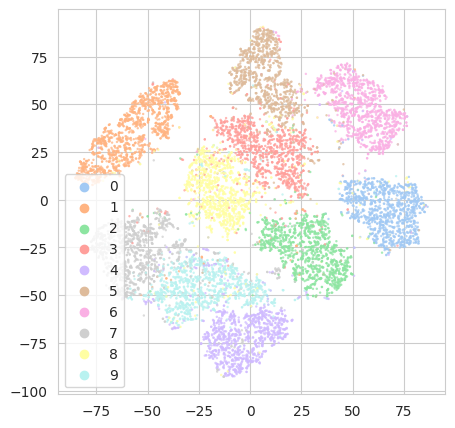

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("pastel")

encoded_tsne = TSNE(verbose = 10, init = "pca", learning_rate = "auto").fit_transform(encoded_inputs)
plt.figure(figsize = (5, 5))
sns.scatterplot(x = encoded_tsne[:,0], y = encoded_tsne[:, 1], hue = classes, alpha = .75, palette="pastel", s = 3, linewidth = 0)
plt.show()

We can see that the model embeds samples of the class together, in clusters.

Next, let's try to generate some new samples.
Remember that our variational autoencoder has been trained to represent samples as gaussians in the bottleneck space. Logically, this makes it possible to now sample random gaussians and retrieve realistic-looking samples after decoding.

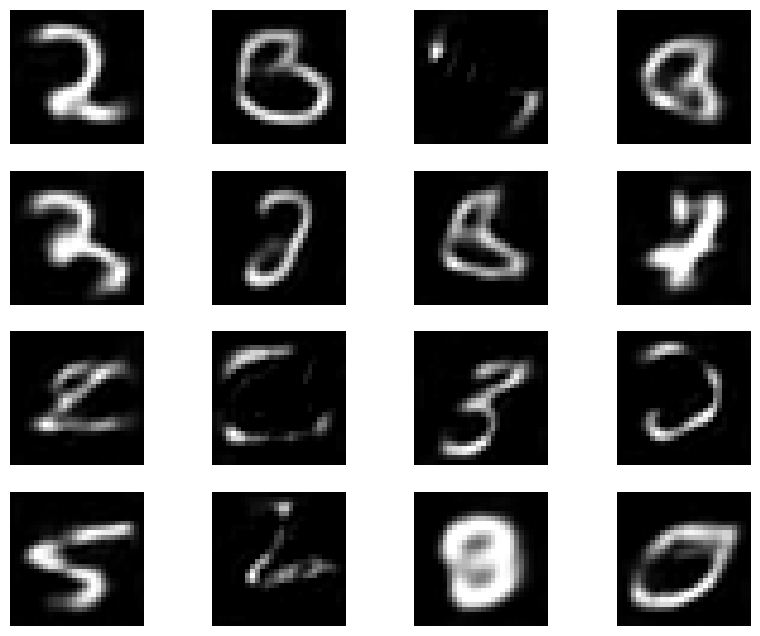

In [ ]:
# generating some random noise
samples = torch.randn(16, 8).to("cuda")
with torch.no_grad():
    model.eval()
    decoded_samples = model.decode(samples)
    decoded_samples = torch.clip(decoded_samples, min = 0, max = 1).cpu().numpy() * 255

figure = plt.figure(figsize=(10, 8))
cols, rows = 4, 4
for i in range(cols * rows):
    img = decoded_samples[i]
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(img.reshape(-1, 28, 28).squeeze(), cmap="gray")
plt.show()